Similar to strategy_09a except that we use log prices to choose correlated triples of coins and to calculate beta and alpha for the portfolio's holdings.

In [ ]:
# Historical snapshot of coins from December 01, 2019: https://coinmarketcap.com/historical/20191201/ used to
# get a representative set of coins from before the period of analysis to avoid look-ahead bias.

strat_univ = [
    'BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BCHUSDT', 'LTCUSDT', 'EOSUSDT', 'BNBUSDT',
    'XLMUSDT', 'TRXUSDT', 'ADAUSDT', 'XTZUSDT', 'LINKUSDT', 'ATOMUSDT',
    'NEOUSDT', 'MKRUSDT', 'DASHUSDT', 'ETCUSDT', 'USDCUSDT', 'ONTUSDT', 'VETUSDT',
    'DOGEUSDT', 'BATUSDT', 'ZECUSDT',
    'SNXUSDT', 'QTUMUSDT', 'TUSDUSDT', 'ZRXUSDT',
    'THXUSDT', 'THRUSDT', 'ALGOUSDT', 'REPUSDT', 'NANOUSDT', 'KBCUSDT', 'BTGUSDT', 'RVNUSDT', 'OMGUSDT',
    'CNXUSDT', 'ABBCUSDT', 'XINUSDT', 'VSYSUSDT', 'SEELEUSDT', 'EONUSDT', 'ZBUSDT', 'EKTUSDT', 'DGBUSDT',
    'BTMUSDT', 'LSKUSDT', 'KMDUSDT', 'SAIUSDT', 'LUNAUSDT', 'KCSUSDT', 'FTTUSDT', 'QNTUSDT', 'SXPUSDT',
    'BDXUSDT', 'GAPUSDT', 'BCDUSDT', 'THETAUSDT', 'ICXUSDT', 'FSTUSDT', 'MATICUSDT', 'SCUSDT', 'EVRUSDT',
    'BTTUSDT', 'MOFUSDT', 'IOSTUSDT', 'MCOUSDT', 'WAVESUSDT', 'XVGUSDT', 'MONAUSDT', 'BTSUSDT', 'BCNUSDT',
    'HCUSDT', 'MAIDUSDT', 'NEXOUSDT', 'ARDRUSDT', 'DXUSDT', 'OKBUSDT', 'FXCUSDT', 'RLCUSDT', 'MBUSDT',
    'BXKUSDT', 'AEUSDT', 'ENJUSDT', 'STEEMUSDT', 'SLVUSDT', 'BRZEUSDT', 'ZILUSDT', 'VESTUSDT', 'ZENUSDT',
    'SOLVEUSDT', 'CHZUSDT', 'NOAHUSDT', 'LAUSDT', 'BTMXUSDT', 'ETNUSDT', 'ENGUSDT', 'ILCUSDT', 'NPXSUSDT',
    'CRPTUSDT', 'GNTUSDT', 'SNTUSDT', 'ELFUSDT', 'JWLUSDT', 'FETUSDT', 'BOTXUSDT', 'NRGUSDT', 'DGDUSDT',
    'EXMRUSDT', 'EURSUSDT', 'AOAUSDT', 'RIFUSDT', 'CIX100USDT', 'BFUSDT', 'XZCUSDT', 'FABUSDT', 'GRINUSDT',
    'NETUSDT', 'VERIUSDT', 'DGTXUSDT', 'KNCUSDT', 'RENUSDT', 'STRATUSDT', 'ETPUSDT', 'NEXUSDT', 'NEWUSDT',
    'BCZEROUSDT', 'GXCUSDT', 'TNTUSDT', 'BTC2USDT', 'PPTUSDT', 'USDKUSDT', 'ELAUSDT', 'IGNISUSDT', 'PLCUSDT',
    'BNKUSDT', 'DTRUSDT', 'RCNUSDT', 'HPTUSDT', 'LAMBUSDT', 'MANAUSDT', 'EDCUSDT', 'BEAMUSDT', 'TTUSDT',
    'AIONUSDT', 'BZUSDT', 'WTCUSDT', 'WICCUSDT', 'LRCUSDT', 'BRDUSDT', 'FCTUSDT', 'NULSUSDT', 'FTMUSDT',
    'IOTXUSDT', 'QBITUSDT', 'XMXUSDT', 'YOUUSDT', 'NASUSDT', 'WAXPUSDT', 'ARKUSDT', 'RDDUSDT', 'GNYUSDT',
    'AGVCUSDT', 'HYNUSDT', 'CVCUSDT', 'WANUSDT', 'WINUSDT', 'LINAUSDT', 'RUSDT', 'PAIUSDT', 'FSNUSDT',
    'FUNUSDT', 'DPTUSDT', 'BHDUSDT', 'LOOMUSDT', 'XACUSDT', 'BUSDUSDT', 'BHPUSDT', 'TRUEUSDT', 'LOKIUSDT',
    'QASHUSDT', 'BNTUSDT', 'DOTUSDT', 'SOLUSDT']

## Load And Structure Data

In [ ]:
from binance.client import Client as bnb_client
from binance.client import BinanceAPIException
from datetime import datetime
import pandas as pd

client = bnb_client(tld='US')

def get_price_data_for_coin(coin, freq, start_date):
    bn_data = client.get_historical_klines(coin, freq, start_date)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

    bn_data = pd.DataFrame(bn_data, columns=columns)
    bn_data['open_time'] = bn_data['open_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    bn_data['close_time'] = bn_data['close_time'].map(lambda x: datetime.utcfromtimestamp(x / 1000))
    return bn_data


def get_price_data_for_universe(freq, start_date):
    px_data = {}

    for coin in strat_univ:
        try:
            px_data[coin] = get_price_data_for_coin(coin, freq, start_date).set_index('open_time')
            print(f"Downloaded data for {coin}.")
        except BinanceAPIException:
            print(f"Couldn't load data for {coin}.")
    
    return px_data

In [ ]:
data_freq = '4h'
look_back_window_size = 30 * 6
look_back_min_periods = 10 * 6
start_datetime = '2020-01-01 00:00:00'
# in_sample_end = pd.to_datetime("2022-12-31 20:00:00")
# out_sample_start = pd.to_datetime("2023-01-01 00:00:00")

In [ ]:
px_data = get_price_data_for_universe(data_freq, start_datetime)

In [ ]:
import numpy as np

px_close = {coin: px_data[coin]["close"] for coin in px_data}
px_close = pd.DataFrame(px_close).astype(float)
px_close.index.rename("datetime", inplace=True)

log_px_close = np.log(px_close)
log_px_close

In [ ]:
from enum import Enum

class CorrSelectionMethod(Enum):
    MAX_CORR = 1
    MIN_CORR = 2

In [ ]:
import statsmodels.api as sm

def has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, log_px_close_window,
                                 correlation_acceptance_threshold):
    if np.isnan(log_px_close_window[coin]).any():
        return False
    num_available_coins = 0
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if (other_coin != coin and (other_coin not in coins_in_a_triple) and \
            (not np.isnan(log_px_close_window[other_coin]).any())):
            num_available_coins += 1
    return num_available_coins >= 2


def update_correlated_coins_to_min_corr(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                                        log_px_close_data, correlation_acceptance_threshold):
    min_corr = 1.0
    min_corr_coin = None
    second_smallest_corr = 1.0
    second_min_corr_coin = None
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if np.isnan(log_px_close_data[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] <= min_corr:
            second_smallest_corr, min_corr = min_corr, corr_matrix.loc[coin, other_coin]
            second_min_corr_coin, min_corr_coin = min_corr_coin, other_coin
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] <= second_smallest_corr:
            second_smallest_corr = corr_matrix.loc[coin, other_coin]
            second_min_corr_coin = other_coin
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(min_corr_coin)
    coins_in_a_triple.add(second_min_corr_coin)
    current_correlated_triples[coin] = pd.DataFrame(
        0.0, columns=[min_corr_coin, second_min_corr_coin, 'alpha', 'residual'], index=[])


def update_correlated_coins_to_max_corr(coin, corr_matrix, coins_in_a_triple, current_correlated_triples,
                                        log_px_close_data, correlation_acceptance_threshold):
    max_corr = -1.0
    max_corr_coin = None
    second_largest_corr = -1.0
    second_largest_corr_coin = None
    for other_coin in corr_matrix[coin][corr_matrix[coin] > correlation_acceptance_threshold].index:
        if np.isnan(log_px_close_data[other_coin]).any():
            continue
        elif other_coin in coins_in_a_triple:
            continue
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= max_corr:
            second_largest_corr, max_corr = max_corr, corr_matrix.loc[coin, other_coin]
            second_largest_corr_coin, max_corr_coin = max_corr_coin, other_coin
        elif other_coin != coin and corr_matrix.loc[coin, other_coin] >= second_largest_corr:
            second_largest_corr = corr_matrix.loc[coin, other_coin]
            second_largest_corr_coin = other_coin
    coins_in_a_triple.add(coin)
    coins_in_a_triple.add(max_corr_coin)
    coins_in_a_triple.add(second_largest_corr_coin)
    current_correlated_triples[coin] = pd.DataFrame(
        0.0, columns=[max_corr_coin, second_largest_corr_coin, 'alpha', 'residual'], index=[])


def get_holdings_df(log_px_close_df, look_back_min_periods, look_back_window_size,
                    correlation_acceptance_threshold, correlation_rejection_threshold,
                    min_data_points_to_transact, z_score_min_threshold, z_score_max_threshold,
                    corr_selection_method):
    holdings_df = pd.DataFrame(0.0, columns = log_px_close_df.columns, index = log_px_close_df.index)
    
    # map from dependent coin to dataframe of successive regression coefficients and residuals
    current_correlated_triples = dict()
    coins_in_a_triple = set()
    
    for index in range(look_back_min_periods, len(holdings_df)):
        window_start = max(index-look_back_window_size, 0)
        log_px_close_window_df = log_px_close_df.iloc[window_start:index]
        
        time_index = log_px_close_df.index[index]
        holdings_df.loc[time_index] = pd.Series(0.0, index=holdings_df.columns)    
        
        corr_matrix = log_px_close_window_df.corr()
        newly_uncorrelated_keys = set()
        for key_coin in current_correlated_triples:
            value_coin_1 = current_correlated_triples[key_coin].columns[0]
            value_coin_2 = current_correlated_triples[key_coin].columns[1]
            
            triple_list = [key_coin, value_coin_1, value_coin_2]
            
            if log_px_close_window_df[triple_list].iloc[-1].isnull().any():
                newly_uncorrelated_keys.add(key_coin)
            elif ((corr_matrix.loc[key_coin, value_coin_1] < correlation_rejection_threshold or \
                   corr_matrix.loc[key_coin, value_coin_2] < correlation_rejection_threshold)):
                newly_uncorrelated_keys.add(key_coin)
        
        for coin in newly_uncorrelated_keys:
            coins_in_a_triple.remove(coin)
            coins_in_a_triple.remove(current_correlated_triples[coin].columns[0])
            coins_in_a_triple.remove(current_correlated_triples[coin].columns[1])
            
            if coin in current_correlated_triples: # only the dependent coin will appear as a key
                del current_correlated_triples[coin]
            
        for coin in holdings_df.columns:
            if (coin not in coins_in_a_triple) and \
                has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, log_px_close_window_df,
                                             correlation_acceptance_threshold) and \
                corr_selection_method == CorrSelectionMethod.MAX_CORR:
                
                update_correlated_coins_to_max_corr(coin, corr_matrix, coins_in_a_triple,
                                                    current_correlated_triples, log_px_close_window_df,
                                                    correlation_acceptance_threshold)
            elif (coin not in coins_in_a_triple) and \
                has_high_corr_pair_available(coin, corr_matrix, coins_in_a_triple, log_px_close_window_df,
                                             correlation_acceptance_threshold) and \
                corr_selection_method == CorrSelectionMethod.MIN_CORR:
                
                update_correlated_coins_to_min_corr(coin, corr_matrix, coins_in_a_triple,
                                                    current_correlated_triples, log_px_close_window_df,
                                                    correlation_acceptance_threshold)
        
        ##################### SPLIT HERE TO REFACTOR INTO SUB-FUNCTIONS
        
        for coin in current_correlated_triples:
            independent_coin_1 = current_correlated_triples[coin].columns[0]
            independent_coin_2 = current_correlated_triples[coin].columns[1]
            
            model = sm.OLS(log_px_close_window_df[coin].iloc[:-1],
                           sm.add_constant(
                               log_px_close_window_df[[independent_coin_1, independent_coin_2]].iloc[:-1]))
            
            result = model.fit()
            result_data = {
                independent_coin_1: result.params[independent_coin_1],
                independent_coin_2: result.params[independent_coin_2],
                'alpha': result.params['const']
            }
            
            estimate = model.predict(
                result.params,
                sm.add_constant(log_px_close_window_df[[independent_coin_1, independent_coin_2]]).iloc[-1]
            )
            result_data['residual'] = log_px_close_window_df[coin].iloc[-1] - estimate
            result_series = pd.Series(result_data)
            current_correlated_triples[coin].loc[index] = result_series
            
            if len(current_correlated_triples[coin]) >= min_data_points_to_transact:
                z_score_look_back_len = min(look_back_window_size, len(current_correlated_triples[coin]))
                look_back_coin_regression_data = current_correlated_triples[coin].iloc[(-z_score_look_back_len):]
                residual_mean = look_back_coin_regression_data['residual'].mean()
                residual_std = look_back_coin_regression_data['residual'].std()
                z_score = (result_data['residual'] - residual_mean) / residual_std
                
                if z_score_min_threshold <= z_score <= z_score_max_threshold:
                    holdings_df.loc[time_index, coin] = -1.0
                    holdings_df.loc[time_index, independent_coin_1] = result_data[independent_coin_1]
                    holdings_df.loc[time_index, independent_coin_2] = result_data[independent_coin_2]
                elif -z_score_max_threshold <= z_score <= -z_score_min_threshold:
                    holdings_df.loc[time_index, coin] = 1.0
                    holdings_df.loc[time_index, independent_coin_1] = -result_data[independent_coin_1]
                    holdings_df.loc[time_index, independent_coin_2] = -result_data[independent_coin_2]
        holdings_df.loc[time_index] = holdings_df.loc[time_index] / holdings_df.loc[time_index].abs().sum()
    
    return holdings_df

In [ ]:
def get_net_return(strat_holdings, ret):
    # assume that strat_holdings have already been shifted back in time to avoid look-ahead bias or that 
    # data does not depend on current time point
    gross_ret = (strat_holdings * ret).sum(axis=1)
    
    turnover = (strat_holdings.fillna(0) - strat_holdings.shift().fillna(0)).abs().sum(axis=1)
    tcost_bps = 20
    return gross_ret.subtract(turnover * tcost_bps * 1e-4, fill_value=0)

In [ ]:
import matplotlib.pyplot as plt

def get_net_returns_with_graph(px_close, holdings_df, plot_title):
    market_returns = px_close / px_close.shift() - 1

    net_returns_ser = get_net_return(holdings_df, market_returns)
    fig = plt.subplots(figsize=(16, 5))
    plt.title(plot_title)
    plt.plot(net_returns_ser.cumsum())
    
    return net_returns_ser

In [ ]:
def get_sharpe_ratio_data(net_returns_ser):
    sr_data = dict()
    sr_data["total sr"] = net_returns_ser.mean() / net_returns_ser.std() * np.sqrt(365 * 6)

    out_sample_start = pd.to_datetime("2023-01-01 00:00:00")
    in_sample_end = out_sample_start - pd.Timedelta(hours=4)

    sr_data["in-sample sr"] = net_returns_ser.loc[:in_sample_end].mean() / net_returns_ser.loc[:in_sample_end].std() * np.sqrt(365 * 6)
    sr_data["out-sample sr"] = net_returns_ser.loc[out_sample_start:].mean() / net_returns_ser.loc[out_sample_start:].std() * np.sqrt(365 * 6)
    sr_series = pd.Series(sr_data)
    return sr_series

In [ ]:
index_selections = []

for z_score_threshold_pair in ((1.0, 10.0), (1.5, 10.0), (2.0, 10.0), (2.5, 10.0), (3.0, 10.0)):
    for correlation_threshold_pair in ((0.9, 0.8), (0.95, 0.90)):
        for corr_selection_method in (CorrSelectionMethod.MAX_CORR, CorrSelectionMethod.MIN_CORR):
            index_selections.append((z_score_threshold_pair, correlation_threshold_pair,
                                     corr_selection_method))
index_selections

In [ ]:
len(index_selections)

###################################################################

In [ ]:
index_selection_index = 19 # update this before beginning on evening of Feb. 18, 2025

In [ ]:
z_score_min_threshold = index_selections[index_selection_index][0][0]
z_score_max_threshold = index_selections[index_selection_index][0][1]
correlation_acceptance_threshold, correlation_rejection_threshold = index_selections[index_selection_index][1]
corr_selection_method = index_selections[index_selection_index][2]

min_data_points_to_transact = 10 * 6

holdings_df = get_holdings_df(log_px_close, look_back_min_periods, look_back_window_size,
                              correlation_acceptance_threshold, correlation_rejection_threshold,
                              min_data_points_to_transact, z_score_min_threshold, z_score_max_threshold,
                              corr_selection_method)
plot_title = f"Cumulative Returns: z_score_min_threshold = {z_score_min_threshold}, z_score_max_threshold = {z_score_max_threshold}, correlation_thresholds = {(correlation_acceptance_threshold, correlation_rejection_threshold)}, {'MIN CORR' if corr_selection_method == CorrSelectionMethod.MIN_CORR else 'MAX CORR'}"
net_returns_ser = get_net_returns_with_graph(px_close, holdings_df, plot_title)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

In [ ]:
net_returns_ser.cumsum().plot()

In [ ]:
sharpe_ratio_ser

In [ ]:
# outcome_df = pd.DataFrame(0.0, columns=["total sr", "in-sample sr", "out-sample sr"],
#                           index=pd.MultiIndex.from_tuples(
#                               [], names=["z-score", "corr thresholds", "corr selection method"]))

outcome_df = pd.read_csv("./strat_09b_results.csv",
                         index_col=["z-score", "corr thresholds", "corr selection method"])

outcome_df

In [ ]:
raw_outcome_data = {"total sr": [], "in-sample sr": [], "out-sample sr": []}
indices = []

for (df_index, df_val) in outcome_df.iterrows():
    dict_index = (tuple(map(float, df_index[0][1:-1].split(','))),
                  tuple(map(float, df_index[1][1:-1].split(','))),
                  df_index[2])
    
    indices.append(dict_index)
    raw_outcome_data["total sr"].append(df_val["total sr"])
    raw_outcome_data["in-sample sr"].append(df_val["in-sample sr"])
    raw_outcome_data["out-sample sr"].append(df_val["out-sample sr"])

raw_outcome_data

In [ ]:
tuple_index = (index_selections[index_selection_index][0],
               index_selections[index_selection_index][1],
               index_selections[index_selection_index][2])

raw_outcome_data["total sr"].append(sharpe_ratio_ser["total sr"])
raw_outcome_data["in-sample sr"].append(sharpe_ratio_ser["in-sample sr"])
raw_outcome_data["out-sample sr"].append(sharpe_ratio_ser["out-sample sr"])
indices.append(tuple_index)

outcome_df = pd.DataFrame(
    raw_outcome_data,
    index=pd.MultiIndex.from_tuples(indices, names=["z-score", "corr thresholds", "corr selection method"])
)
# outcome_df.index.set_names(["z-score", "corr thresholds", "corr selection method"], inplace=True)
outcome_df

In [ ]:
outcome_df.to_csv("./strat_09b_results.csv")

################################################################

## Best Case With Correlation Acceptance Threshold Reduced To 0.85 And Correlation Rejection Threshold Reduced To 0.70

In [ ]:
holdings_df = get_holdings_df(log_px_close, look_back_min_periods, look_back_window_size,
                              0.85, 0.7,
                              10*6, 3.0, 10.0,
                              CorrSelectionMethod.MIN_CORR)
net_returns_ser = get_net_returns_with_graph(px_close, holdings_df, plot_title)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

In [ ]:
sharpe_ratio_ser

In [ ]:
net_returns_ser.cumsum().plot()

###############################################################################

## Best Case With Min Periods To Transact Reduced From 10 * 6 To 5 * 6

In [ ]:
holdings_df = get_holdings_df(log_px_close, look_back_min_periods, look_back_window_size,
                              0.90, 0.80,
                              5*6, 3.0, 10.0,
                              CorrSelectionMethod.MIN_CORR)
net_returns_ser = get_net_returns_with_graph(px_close, holdings_df, plot_title)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

In [ ]:
sharpe_ratio_ser

In [ ]:
net_returns_ser.cumsum().plot()

############################################################

## Best Case With Min Periods To Transact Reduced To 5 * 6 And Correlation Thresholds Changes To (0.85, 0.7)

In [ ]:
holdings_df = get_holdings_df(log_px_close, look_back_min_periods, look_back_window_size,
                              0.85, 0.70,
                              5*6, 3.0, 10.0,
                              CorrSelectionMethod.MIN_CORR)
net_returns_ser = get_net_returns_with_graph(px_close, holdings_df, plot_title)
sharpe_ratio_ser = get_sharpe_ratio_data(net_returns_ser)

In [52]:
sharpe_ratio_ser

total sr         0.935912
in-sample sr     0.355936
out-sample sr    1.446474
dtype: float64

<Axes: xlabel='datetime'>

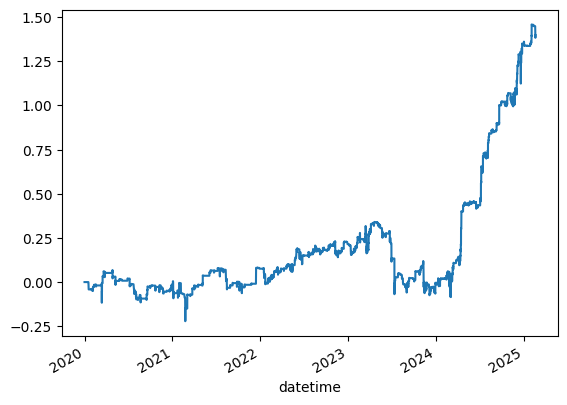

In [53]:
net_returns_ser.cumsum().plot()

#######################################################

(2.0,10.0), (0.95,0.9), MIN_CORR - relatively stable results

(2.5,10.0), (0.95,0.9), MAX_CORR - relatively stable results

(2.5,10.0), (0.95,0.9), MIN_CORR - relatively stable results

In [ ]:
def clear_outcome_df_and_write_to_csv():
    outcome_df = pd.DataFrame(0.0, columns=["total sr", "in-sample sr", "out-sample sr"],
                          index=pd.MultiIndex.from_tuples(
                              [], names=["z-score", "corr thresholds", "corr selection method"]))
    outcome_df.to_csv("./strat_09b_results.csv")